In [1]:
import gzip
import csv

phedex_columns= ['now_sec','dataset_name','dataset_id','dataset_is_open','create_time',
                'update_time','block_name','block_id','block_files','block_bytes',
                'block_is_open','block_time_create','block_time_update',
                'node_name','node_id','br_is_active','br_src_files',
                'br_src_bytes','br_dest_files','br_dest_bytes',
                'br_node_files','br_node_btyes','br_xfer_files',
                'br_xfer_bytes','br_is_custodial','br_user_group_id',
                'replica_time_create','replica_time_updater']
phedex_colmap={}
for i in range(len(phedex_columns)):
    phedex_colmap[phedex_columns[i]]=i

dataset_col=phedex_colmap['dataset_name']
site_col=phedex_colmap['node_name']
block_col=phedex_colmap['block_name']
replicaTime_col=phedex_colmap['replica_time_create']
size_col=phedex_colmap['block_bytes']
phedex_info={}
n=0
fmt='%Y-%m-%d'
import datetime
import numpy
sumBytes=0
with gzip.open('phedex.out.gz') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if 'MSS' not in row[site_col]: continue

        t=datetime.datetime.fromtimestamp(float(row[replicaTime_col]))
#        tf=t.strftime(fmt)
        rTime=numpy.datetime64(t)
        key=(row[dataset_col],row[block_col],row[site_col])
        if key in phedex_info:
            print 'duplicate',key
            break
        phedex_info[key]=(rTime,float(row[size_col]))
        sumBytes+=float(row[size_col])
            
        if n==0:
            for i in range(len(phedex_columns)):
                print i,row[i],phedex_columns[i]
        #if n==3: break
        n=n+1
     
print("Done reading phedex info")
print len(phedex_info)
print sumBytes

0 1571449759.999999999999999999999999999998 now_sec
1 /RPCMonitor/Run2012A-v1/RAW dataset_name
2 526938 dataset_id
3 y dataset_is_open
4 1333632476.11171 create_time
5 null update_time
6 /RPCMonitor/Run2012A-v1/RAW#75d8a3ba-9094-11e1-9605-003048caaace block_name
7 3424346 block_id
8 1 block_files
9 511604 block_bytes
10 n block_is_open
11 1335550322.15432 block_time_create
12 1335553821.36606 block_time_update
13 T1_DE_KIT_MSS node_name
14 1262 node_id
15 n br_is_active
16 0 br_src_files
17 0 br_src_bytes
18 1 br_dest_files
19 511604 br_dest_bytes
20 1 br_node_files
21 511604 br_node_btyes
22 0 br_xfer_files
23 0 br_xfer_bytes
24 y br_is_custodial
25 18 br_user_group_id
26 1378299610 replica_time_create
27 1471160633.17911 replica_time_updater
Done reading phedex info
4788650
2.24804669121e+17


In [2]:

dates=sorted(set([i[0] for i in phedex_info.values()]))

print dates[0],dates[-1]

2007-06-01T17:28:00.520030 2019-10-19T02:43:03.000000


In [11]:

histo=numpy.zeros(1+ int( (dates[-1]-dates[0]) / numpy.timedelta64(1,'D')) )
histoCERN=numpy.zeros(1+ int( (dates[-1]-dates[0]) / numpy.timedelta64(1,'D')) )
tiers=['AOD','RAW','GEN-SIM-RECO','GEN-SIM-DIGI-RAW','RAW-RECO','ALCARECO','Other']
histoTier={}
histoTierCERN={}
for t in tiers:
    histoTier[t]=numpy.zeros(1+ int( (dates[-1]-dates[0]) / numpy.timedelta64(1,'D')) )
    histoTierCERN[t]=numpy.zeros(1+ int( (dates[-1]-dates[0]) / numpy.timedelta64(1,'D')) )
    
dateList=numpy.arange(dates[0],dates[-1],numpy.timedelta64(1,'D'))
#print len(dateList)
#print len(histo)

keys=phedex_info.keys()
sites={}
for k in keys:
    bin=int( (phedex_info[k][0]-dates[0])/numpy.timedelta64(1,'D'))
    tier=k[0].split('/')[-1]
    if tier not in tiers:
        if 'AOD' in tier: tier='AOD'
        else:
            tier='Other'
            
    val=phedex_info[k][1]/1024./1024./1024./1024./1024.
    histo[bin] +=val
    histoTier[tier][bin] +=val
    if 'CERN' in k[2]:
        histoCERN[bin] +=val
        histoTierCERN[tier][bin] +=val
    sites[k[2]]=sites.get(k[2],0.)+val

#print histo[0:100]

#at cern there is the castor space
castorSpace= (81060 - 69829)/1024.
histo[0]+=castorSpace
histoCERN[0]+=castorSpace
histoTierCERN['Other'][0]+=castorSpace
sites['T0_CH_CERN_MSS']+=castorSpace

cumsum=numpy.cumsum(histo)
cumsumCERN=numpy.cumsum(histoCERN)
cumsumTier={}
cumsumTierCERN={}
for tier in tiers:
    cumsumTier[tier]=numpy.cumsum(histoTier[tier])
    cumsumTierCERN[tier]=numpy.cumsum(histoTierCERN[tier])
for site in sites:
    print site,sites[site]

T1_RU_JINR_MSS 6.28616206751
T1_FR_CCIN2P3_MSS 12.5735244783
T1_IT_CNAF_MSS 18.0491449234
T1_DE_KIT_MSS 14.7953522008
T1_US_FNAL_MSS 58.2702129426
T1_ES_PIC_MSS 6.00341216568
T1_UK_RAL_MSS 11.03267226
T0_CH_CERN_MSS 83.6239481602


Last six months total 19.886647241340683
Last six months Tier-1 13.15605202138687
Last six months Tier-0 6.730595219953813
Total 210.63442919833966
Tier-1 127.01048103815326
Tier-0 83.6239481601864


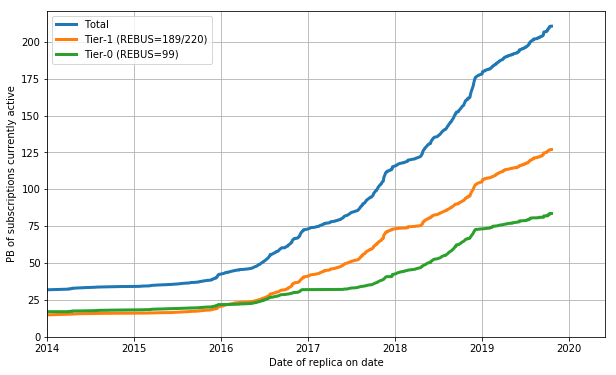

In [12]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = 10, 6

pylab.plot(dateList,cumsum,linewidth=3)
pylab.plot(dateList,cumsum-cumsumCERN,linewidth=3)
pylab.plot(dateList,cumsumCERN,linewidth=3)

pylab.xlabel('Date of replica on date')
pylab.ylabel('PB of subscriptions currently active')
pylab.ylim(ymin=0)
pylab.xlim(xmin=numpy.datetime64('2014-01-01'))
pylab.legend(['Total','Tier-1 (REBUS=189/220)','Tier-0 (REBUS=99)'],loc='best')
pylab.grid()

print 'Last six months total',cumsum[-1]-cumsum[-180]
print 'Last six months Tier-1',(cumsum[-1]-cumsumCERN[-1])-(cumsum[-180]-cumsumCERN[-180])
print 'Last six months Tier-0',cumsumCERN[-1]-cumsumCERN[-180]

print 'Total',cumsum[-1]
print 'Tier-1',(cumsum[-1]-cumsumCERN[-1])
print 'Tier-0',cumsumCERN[-1]




In [30]:
import json
import urllib2
url = "http://cmsmonitoring.web.cern.ch/cmsmonitoring/storageoverview/latest/StorageOverview.json"
response = urllib2.urlopen(url)
data = response.read()
values = json.loads(data)
tape = values["Tape"]["Used"]
# CERN will not agree as I added the Castor space above
for sitename in tape:
    print sitename,tape[sitename],int(1024.*sites[sitename]),int(1.0995116*1024.*sites[sitename])

 T1_RU_JINR_MSS 7073 6437 7077
T1_FR_CCIN2P3_MSS 14150 12875 14156
T1_IT_CNAF_MSS 19652 18482 20321
T1_DE_KIT_MSS 16661 15150 16658
T1_US_FNAL_MSS 65437 59668 65606
T1_ES_PIC_MSS 6735 6147 6759
T1_UK_RAL_MSS 12421 11297 12421
T0_CH_CERN_MSS 81791 85630 94152


In [14]:
#this is the error introduced if you use 10^9 bytes = 1GB 
1.024*1.024*1.024*1.024

1.0995116277760002

In [35]:
#keys=phedex_info.keys()
#tiers1={}
#tiers0={}
#for k in keys:
#    tier=k[0].split('/')[-1]
#    if 'CERN' in k[2]:
#        tiers0[tier]=tiers0.get(tier,0.)+phedex_info[k][1]/1024./1024./1024./1024./1024.
#    else:
#        tiers1[tier]=tiers1.get(tier,0.)+phedex_info[k][1]/1024./1024./1024./1024./1024.
#        
for t in cumsumTier:
    t1=int(100*(cumsumTier[t][-1]-cumsumTierCERN[t][-1]))/100.
    t0=int(100*cumsumTierCERN[t][-1])/100.
    t1old=int(100*(cumsumTier[t][-180]-cumsumTierCERN[t][-180]))/100.
    t0old=int(100*cumsumTierCERN[t][-180])/100.
    print t,t1,t0,t1-t1old,t0-t0old
    

ALCARECO 8.49 0.78 1.02 0.02
AOD 47.0 13.32 7.06 3.83
GEN-SIM-DIGI-RAW 7.04 1.94 0.84 0.37
GEN-SIM-RECO 8.03 2.38 0.24 0.0
RAW 33.42 46.12 0.31 0.01
RAW-RECO 5.47 1.61 0.44 1.46
Other 6.54 17.45 3.23 1.05


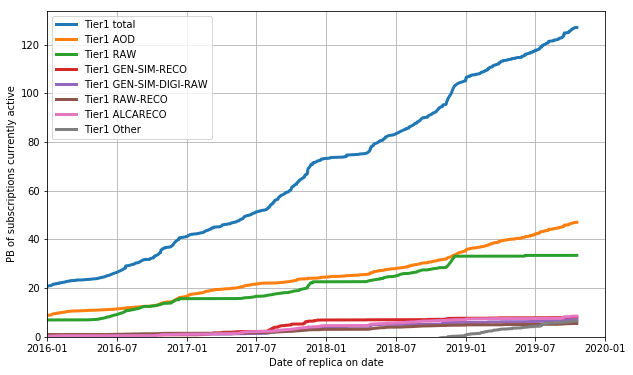

In [33]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = 10, 6

legList=['Tier1 total']
pylab.plot(dateList,cumsum-cumsumCERN,linewidth=3)
for tier in tiers:
   pylab.plot(dateList,cumsumTier[tier]-cumsumTierCERN[tier],linewidth=3) 
   legList.append('Tier1 '+tier)

pylab.xlabel('Date of replica on date')
pylab.ylabel('PB of subscriptions currently active')
pylab.ylim(ymin=0)
pylab.xlim(xmin=numpy.datetime64('2016-01-01'))
pylab.xlim(xmax=numpy.datetime64('2020-01-01'))
pylab.legend(legList,loc='best')
pylab.grid()



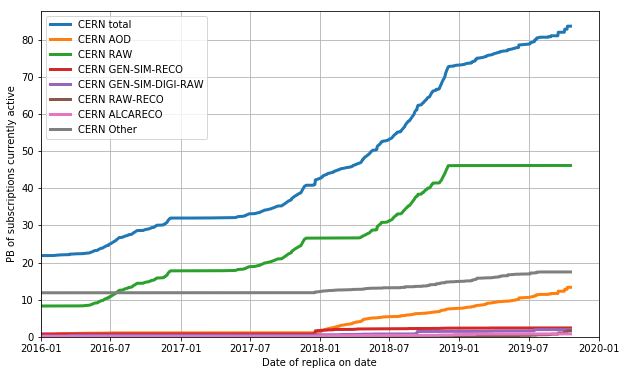

In [19]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = 10, 6

legList2=['CERN total']
pylab.plot(dateList,cumsumCERN,linewidth=3)
for tier in tiers:
   pylab.plot(dateList,cumsumTierCERN[tier],linewidth=3) 
   legList2.append('CERN '+tier)

pylab.xlabel('Date of replica on date')
pylab.ylabel('PB of subscriptions currently active')
pylab.ylim(ymin=0)
pylab.xlim(xmin=numpy.datetime64('2016-01-01'))
pylab.xlim(xmax=numpy.datetime64('2020-01-01'))
pylab.legend(legList2,loc='best')
pylab.grid()

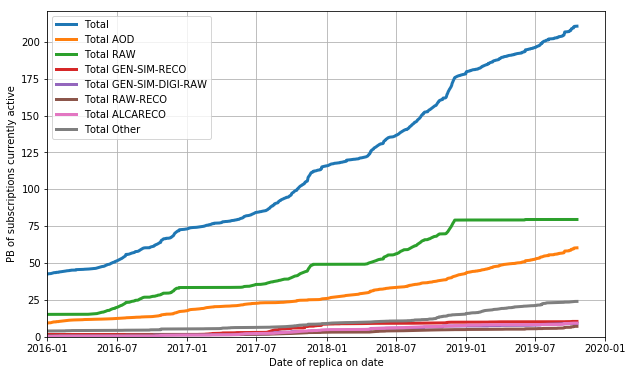

In [22]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = 10, 6

legList2=['Total']
pylab.plot(dateList,cumsum,linewidth=3)
for tier in tiers:
   pylab.plot(dateList,cumsumTier[tier],linewidth=3) 
   legList2.append('Total '+tier)

pylab.xlabel('Date of replica on date')
pylab.ylabel('PB of subscriptions currently active')
pylab.ylim(ymin=0)
pylab.xlim(xmin=numpy.datetime64('2016-01-01'))
pylab.xlim(xmax=numpy.datetime64('2020-01-01'))
pylab.legend(legList2,loc='best')
pylab.grid()